In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [32]:
ticker = yf.Ticker("BTC-USD")
data = ticker.history(period="5y")
data["Prediction"] = data["Close"].shift(-1)

In [33]:
data["MA7"] = data["Close"].rolling(window=7).mean()
data['MA30'] = data['Close'].rolling(window=30).mean()

In [34]:
data['Diff'] = data['Close'].diff()
data['Gain'] = data['Diff'].clip(lower=0)
data['Loss'] = data['Diff'].clip(upper=0).abs()
data['Avg_Gain'] = data['Gain'].ewm(alpha=1/14, adjust=False).mean()
data['Avg_Loss'] = data['Loss'].ewm(alpha=1/14, adjust=False).mean()
data['RS'] = data['Avg_Gain'] / data['Avg_Loss']
data['RSI'] = 100 - (100 / (1 + data['RS']))

In [35]:
data['Target_Return'] = (data['Prediction'] - data['Close']) / data['Close']

In [36]:
data.dropna(inplace=True)

In [37]:
features = ['Close', 'Volume', 'MA7', 'MA30', 'RSI']
x = data[features]
y = data['Target_Return']

In [38]:
split_index = len(data) - 500
x_train = x.iloc[:split_index]
x_test = x.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

In [39]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [40]:
pred_returns = rf_model.predict(x_test)
mae = mean_absolute_error(y_test, pred_returns)
print(f"Средняя ошибка (MAE): {mae:.5f} ({mae*100:.2f}%)")

Средняя ошибка (MAE): 0.02674 (2.67%)


In [ ]:
last_day_features = data[features].iloc[-1:]
prediction_tomorrow = rf_model.predict(last_day_features)
print(f"Прогноз доходности на завтра: {prediction_tomorrow[0]:.4f}")
print(f"В процентах: {prediction_tomorrow[0] * 100:.2f}%")

Прогноз доходности на завтра: -0.0272
В процентах: -2.72%


In [42]:
last_close = data["Close"].iloc[-1]
prediction_price = last_close * (1 + prediction_tomorrow[0])
print(f"Сегодняшняя цена: {last_close:.2f}")
print(f"Ожидаемая цена завтра: {prediction_price:.2f}")

Сегодняшняя цена: 90603.19
Ожидаемая цена завтра: 88138.26


In [43]:
tree_prediction = [tree.predict(last_day_features.values)[0] for tree in rf_model]
down_votes = sum(1 for p in tree_prediction if p < 0)
up_votes = sum(1 for p in tree_prediction if p > 0)


print(f"Голоса за ПАДЕНИЕ: {down_votes}")
print(f"Голоса за РОСТ: {up_votes}")


print(f"Самый пессимистичный прогноз: {min(tree_prediction)*100:.2f}%")
print(f"Самый оптимистичный прогноз: {max(tree_prediction)*100:.2f}%")

Голоса за ПАДЕНИЕ: 81
Голоса за РОСТ: 19
Самый пессимистичный прогноз: -6.10%
Самый оптимистичный прогноз: 7.80%


<>:7: SyntaxWarning: invalid escape sequence '\D'
<>:7: SyntaxWarning: invalid escape sequence '\D'
C:\Temp\ipykernel_18468\3842163657.py:7: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('Доходность ($\Delta$)', fontsize=12)


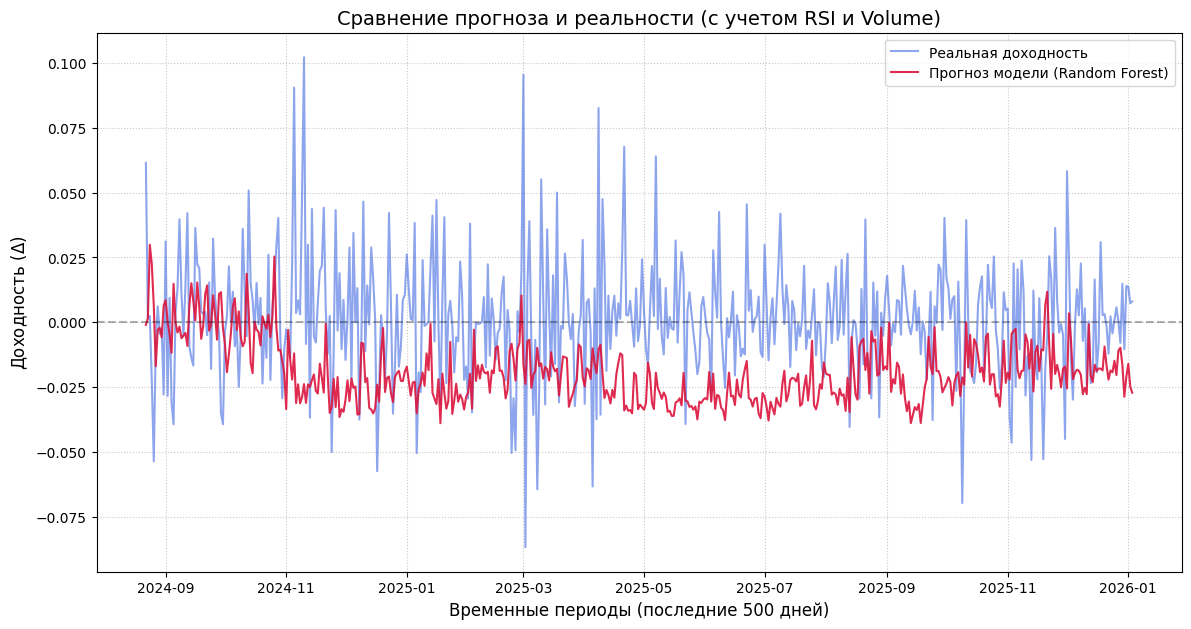

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(y_test.index, y_test.values, label='Реальная доходность', color='royalblue', alpha=0.6, linewidth=1.5)
plt.plot(y_test.index, pred_returns, label='Прогноз модели (Random Forest)', color='crimson', alpha=0.9, linewidth=1.5)
plt.axhline(0, color='black', linestyle='--', alpha=0.3)
plt.title('Сравнение прогноза и реальности (с учетом RSI и Volume)', fontsize=14)
plt.xlabel('Временные периоды (последние 500 дней)', fontsize=12)
plt.ylabel('Доходность', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)